In [2]:
from art.utils import load_dataset
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import CarliniLInfMethod
from art.metrics import empirical_robustness


import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Loading hand writing dataset

In [3]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=10000):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [4]:
mnist = tf.keras.datasets.mnist # Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data

# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [5]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [6]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (12665, 28, 28)
Lengh of dimensions for y_train:  (12665,)
Lengh of dimensions for x_test:  (2115, 28, 28)
Lengh of dimensions for y_test:  (2115,)


In [7]:
'''reshape'''
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [8]:
'''Normalization'''
#x_train = x_train / 255.0
#y_train = y_train / 255.0

'Normalization'

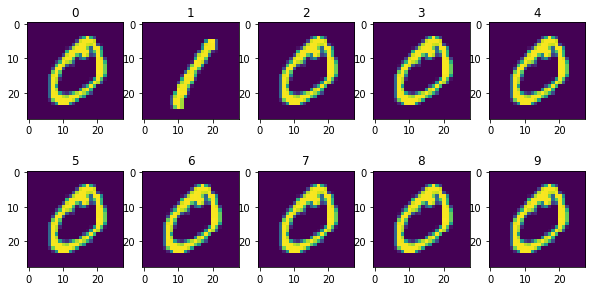

In [9]:
n_classes = 10
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [10]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_object,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [11]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
396/396 [==============================] - 10s 23ms/step - loss: 0.1761 - accuracy: 0.9584 - val_loss: 0.0057 - val_accuracy: 0.9986
Epoch 2/5
396/396 [==============================] - 7s 18ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 3/5
396/396 [==============================] - 8s 20ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 0.9995
Epoch 4/5
396/396 [==============================] - 8s 20ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 6.6721e-04 - val_accuracy: 0.9995
Epoch 5/5
396/396 [==============================] - 8s 20ms/step - loss: 6.8784e-04 - accuracy: 0.9998 - val_loss: 3.3319e-04 - val_accuracy: 1.0000


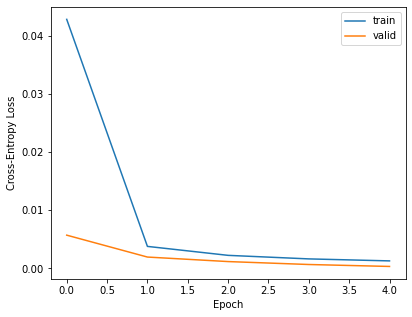

In [12]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.4f' % score[1])

Test cross-entropy loss: 0.00033
Test accuracy: 1.0000


# Carlini and Wagner l2

In [17]:
'''wrap the model an calculte emperical robustnees'''
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28,28,1), clip_values=(0, 1),
                                   loss_object = loss_object)

In [21]:
# eps_list=np.arange(0.01, 0.51, 0.05)
eps_list=np.arange(0.1, 0.5, 0.01)

acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    adv_cw_model = CarliniL2Method(classifier, binary_search_steps=eps_list[i]*784, targeted=False)
    adv_cw_x = adv_cw_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_cw_x)
    acc[i]=classifier._model.evaluate(adv_cw_x, y_test)[1]
    print(eps_list[i])

ValueError: The number of binary search steps must be a non-negative integer.

# Carlini and Wagner linf

In [23]:
eps_list=np.arange(0.01, 0.51, 0.05)

acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    adv_cw_model = CarliniLInfMethod(classifier, eps=eps_list[i], targeted=False)
    adv_cw_x = adv_cw_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_cw_x)
    acc[i]=classifier._model.evaluate(adv_cw_x, y_test)[1]
    print(eps_list[i])


67/67 [==============================] - 0s 5ms/step - loss: 0.0187 - accuracy: 0.9920
0.01



67/67 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9920
0.060000000000000005



67/67 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9920
0.11



67/67 [==============================] - 0s 4ms/step - loss: 0.0187 - accuracy: 0.9920
0.16000000000000003



67/67 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9920
0.21000000000000002


KeyboardInterrupt: 

In [31]:
adv_cw_model = CarliniLInfMethod(classifier, eps=0.1*28*28, targeted=False)
adv_cw_x = adv_cw_model.generate(x=x_test)
prediction_x = classifier.predict(x=adv_cw_x)
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_cw_x, y_test)[1])


accuracy on adversarial examples:
67/67 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9920
0.991962194442749


# ---------------------------------------------------

In [110]:
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_pgd_x, y_test)[1])

accuracy on adversarial examples:
67/67 [==============================] - 0s 3ms/step - loss: 29.6084 - accuracy: 4.7281e-04
0.00047281323350034654


Test cross-entropy loss: 0.00270
Test accuracy: 0.99905


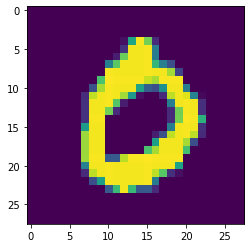

In [61]:
'''Score on adversarial examples'''
score = model.evaluate(adv_pgd_x, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_pgd_x[0])  
plt.show()